# 04 — Backtest + Monte Carlo

## Key Findings Summary (December 16, 2025)

**Confirmed Strategy Parameters:**
- **Markets**: BTC + ETH only (15min + 1hour Up/Down)
- **Best Market**: 15min-BTC (70% of total PnL)
- **Timing**: 10-15 min before resolution (optimal window)
- **Direction**: DOWN bets win 55.9% vs UP 47% → FAVOR DOWN
- **Execution**: 82% of PnL from execution edge → MAKER orders at bid+1

**Monte Carlo Results:**
| Scenario | Median PnL | Sharpe | 5th Percentile |
|----------|------------|--------|----------------|
| Maker    | $9,328     | 7.35   | +$5,161        |
| Actual   | $1,271     | 1.01   | -$20           |

**Expected Improvement: 8x PnL with maker execution**

---

Goal: stress‑test hypotheses about `gabagool22` using only what we have in ClickHouse.

This notebook:
- Uses **settlement PnL** (profit/loss at market resolution).
- Aggregates trades into short **units** (market + time bucket) to avoid treating split orders as independent.
- Runs a **circular block bootstrap** over time‑ordered unit PnL to estimate distributions of total PnL + drawdown.
- Compares execution‑price scenarios (actual vs mid vs exec‑proxy), plus explicit upper/lower bounds.

Limitations:
- Not a full execution simulator (no queue position / fill probability).
- If we later observe SELL trades / early exits, we should switch to a proper position ledger.


In [1]:
username = "gabagool22"

# If None, auto-pick latest snapshot for this username.
snapshot_dir = None

# Execution-price scenarios to compare.
# - actual: observed trade price
# - mid: entry at mid (benchmark)
# - exec_proxy: entry based on exec_type proxy (maker/taker/inside)
# - all_maker/all_taker: explicit upper/lower bounds (ignore fill probability)
scenarios = ["actual", "exec_proxy", "mid", "all_maker", "all_taker"]

# Unit bucketing:
# If the snapshot already has a `bucket` column from 02_*, we use it.
# Otherwise we compute it with this window.
unit_bucket_seconds = 10

# Bootstrap settings (increase later if needed).
bootstrap_iters = 20_000
block_len = 50

# Only use trades with settle_price available.
only_resolved = True


In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "research" / "snapshot.py").exists():
            return p
    raise RuntimeError(
        "Cannot locate repo root (expected to find `research/snapshot.py`). "
        "Start Jupyter from the repo root or set REPO_ROOT=/path/to/polybot."
    )


repo_root_env = os.getenv("REPO_ROOT")
repo_root = Path(repo_root_env) if repo_root_env else _find_repo_root(Path.cwd())
sys.path.insert(0, str(repo_root))

from research.backtest import (
    block_bootstrap,
    compute_trade_cost,
    compute_trade_pnl,
    load_features,
    summarize_pnl,
)


In [3]:
loaded = load_features(username=username, snapshot_dir=snapshot_dir)
df = loaded.features.copy()

df["ts"] = pd.to_datetime(df["ts"], errors="coerce", utc=True)
df["end_date"] = pd.to_datetime(df.get("end_date"), errors="coerce", utc=True)

if "bucket" not in df.columns:
    df["bucket"] = df["ts"].dt.floor(f"{int(unit_bucket_seconds)}s")

df["settle_price"] = pd.to_numeric(df.get("settle_price"), errors="coerce")
df["realized_pnl"] = pd.to_numeric(df.get("realized_pnl"), errors="coerce")
df["tob_known"] = pd.to_numeric(df.get("tob_known"), errors="coerce").fillna(0).astype(int)

resolved = df.copy()
if only_resolved:
    resolved = resolved[resolved["settle_price"].notna()].copy()

print("snapshot:", loaded.snapshot_path)
print("rows:", len(df), "resolved:", len(resolved), f"resolved_pct={len(resolved)/len(df):.1%}")
print("tob_known (resolved):", resolved["tob_known"].mean())

resolved[["ts", "market_slug", "asset", "outcome", "price", "size", "settle_price", "realized_pnl", "tob_known"]].head()


snapshot: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251216T171416+0000
rows: 18629 resolved: 15573 resolved_pct=83.6%
tob_known (resolved): 0.8584087844345983


,ts,market_slug,asset,outcome,price,size,settle_price,realized_pnl,tob_known
48,2025-12-15 13:02:25+00:00,bitcoin-up-or-down-december-15-8am-et,,Down,0.46,18.0,0.9995,9.711,0
49,2025-12-15 13:02:31+00:00,bitcoin-up-or-down-december-15-8am-et,,Down,0.49,18.0,0.9995,9.171,0
50,2025-12-15 13:03:21+00:00,bitcoin-up-or-down-december-15-8am-et,,Down,0.60,10.0,0.9995,3.995,0
51,2025-12-15 13:04:05+00:00,bitcoin-up-or-down-december-15-8am-et,,Down,0.57,18.0,0.9995,7.731,0
52,2025-12-15 13:04:05+00:00,bitcoin-up-or-down-december-15-8am-et,,Down,0.57,18.0,0.9995,7.731,0


## Scenario meaning

- `actual`: what the data says happened (uses `realized_pnl` when present).
- `mid`: benchmark vs TOB mid.
- `exec_proxy`: uses `exec_type` proxy:
  - BUY: `MAKER_LIKE`→bid, `TAKER_LIKE`→ask, `INSIDE`→mid; else uses actual.
  - SELL: `MAKER_LIKE`→ask, `TAKER_LIKE`→bid, `INSIDE`→mid; else uses actual.
- `all_maker` / `all_taker`: **bounds only** (ignore fill probability and queue).

We run each scenario in two modes:

- **all_resolved**: keep all resolved trades; scenarios fall back to actual price when TOB is missing.
- **tob_known_only**: only use trades where TOB is known; scenarios do not fall back to actual.


In [4]:
def run_scenario(frame: pd.DataFrame, scenario: str, *, fallback_to_actual: bool) -> dict:
    pnl = compute_trade_pnl(frame, scenario=scenario, fallback_to_actual=fallback_to_actual)
    cost = compute_trade_cost(frame, scenario=scenario, fallback_to_actual=fallback_to_actual)
    tmp = frame.assign(pnl=pnl, cost=cost)

    tmp = tmp[tmp["pnl"].notna()].copy()
    tmp["pnl_ts"] = tmp["end_date"].where(tmp["end_date"].notna(), tmp["ts"])

    units = (
        tmp.groupby(["market_slug", "bucket"], dropna=False, as_index=False)
        .agg(
            pnl=("pnl", "sum"),
            cost=("cost", "sum"),
            pnl_ts=("pnl_ts", "max"),
            trades=("pnl", "size"),
        )
        .sort_values("pnl_ts")
        .reset_index(drop=True)
    )
    units["roi"] = units["pnl"] / units["cost"].replace(0, np.nan)

    pnl_arr = pd.to_numeric(units["pnl"], errors="coerce").to_numpy()
    summary = summarize_pnl(pnl_arr)
    win_rate = float(np.mean(pnl_arr[np.isfinite(pnl_arr)] > 0)) if np.isfinite(pnl_arr).any() else float("nan")
    boot = block_bootstrap(pnl_arr, iters=bootstrap_iters, block_len=block_len)

    return {
        "scenario": scenario,
        "units": int(summary.get("n", 0)),
        "trades": int(len(tmp)),
        "pnl_sum": float(summary.get("sum", 0)),
        "pnl_mean": float(summary.get("mean", float("nan"))),
        "pnl_std": float(summary.get("std", float("nan"))),
        "win_rate": win_rate,
        "max_drawdown": float(summary.get("max_drawdown", float("nan"))),
        "boot_total_p50": float(boot.get("total_pnl", {}).get("p50", float("nan"))),
        "boot_total_p05": float(boot.get("total_pnl", {}).get("p05", float("nan"))),
        "boot_total_p95": float(boot.get("total_pnl", {}).get("p95", float("nan"))),
        "boot_dd_p50": float(boot.get("max_drawdown", {}).get("p50", float("nan"))),
        "units_df": units,
    }


def run_all(frame: pd.DataFrame, *, fallback_to_actual: bool, label: str) -> tuple[pd.DataFrame, dict[str, pd.DataFrame]]:
    rows = []
    units_by_scenario: dict[str, pd.DataFrame] = {}
    for scenario in scenarios:
        result = run_scenario(frame, scenario, fallback_to_actual=fallback_to_actual)
        units_by_scenario[scenario] = result.pop("units_df")
        result["mode"] = label
        result["fallback_to_actual"] = fallback_to_actual
        rows.append(result)

    summary_df = pd.DataFrame(rows).sort_values("pnl_sum", ascending=False)
    return summary_df, units_by_scenario


In [5]:
# Mode A: use all resolved trades; scenarios fall back to actual when TOB is missing.
summary_all, units_all = run_all(resolved, fallback_to_actual=True, label="all_resolved")
summary_all


,scenario,units,trades,pnl_sum,pnl_mean,pnl_std,win_rate,max_drawdown,boot_total_p50,boot_total_p05,boot_total_p95,boot_dd_p50,mode,fallback_to_actual
3,all_maker,5540,15573,9810.96792,1.770933,21.192815,0.517148,917.478105,9642.584275,5129.184017,14922.214631,751.598295,all_resolved,True
0,actual,5540,15573,2057.86632,0.371456,20.308809,0.506137,802.785405,2054.113750,-47.374667,4124.447422,925.002887,all_resolved,True
1,exec_proxy,5540,15573,1058.60642,0.191084,19.804183,0.503069,858.983480,1053.428445,-1004.615803,3086.221302,1097.632597,all_resolved,True
2,mid,5540,15573,1016.18837,0.183428,19.807445,0.502708,870.169880,1012.103285,-1047.351504,3039.994229,1108.117280,all_resolved,True
4,all_taker,5540,15573,-7970.48348,-1.438715,21.083585,0.491336,8680.314820,-7843.225145,-13137.405098,-3267.792155,8380.502397,all_resolved,True


In [6]:
# Mode B (TOB missingness stress): only trades where TOB is known; no fallback.
resolved_tob = resolved[resolved["tob_known"] == 1].copy()
summary_tob, units_tob = run_all(resolved_tob, fallback_to_actual=False, label="tob_known_only")
summary_tob

,scenario,units,trades,pnl_sum,pnl_mean,pnl_std,win_rate,max_drawdown,boot_total_p50,boot_total_p05,boot_total_p95,boot_dd_p50,mode,fallback_to_actual
3,all_maker,4739,13368,9188.95069,1.939006,21.730214,0.516776,743.554355,9016.635398,4490.274925,14284.573136,802.991142,tob_known_only,False
0,actual,4739,13368,1115.66559,0.235422,20.728408,0.501372,783.214155,1113.787003,-1077.566793,3290.268016,1149.379608,tob_known_only,False
1,exec_proxy,4739,13368,116.40569,0.024563,20.148344,0.497995,941.872690,121.091533,-2083.692651,2263.152036,1439.032093,tob_known_only,False
2,mid,4739,13368,73.98764,0.015613,20.152106,0.497573,963.038190,78.041028,-2123.817097,2219.336737,1452.020162,tob_known_only,False
4,all_taker,4739,13368,-9040.97541,-1.907781,21.543123,0.483013,9257.918015,-8883.865460,-13995.506140,-4340.339087,9305.819520,tob_known_only,False


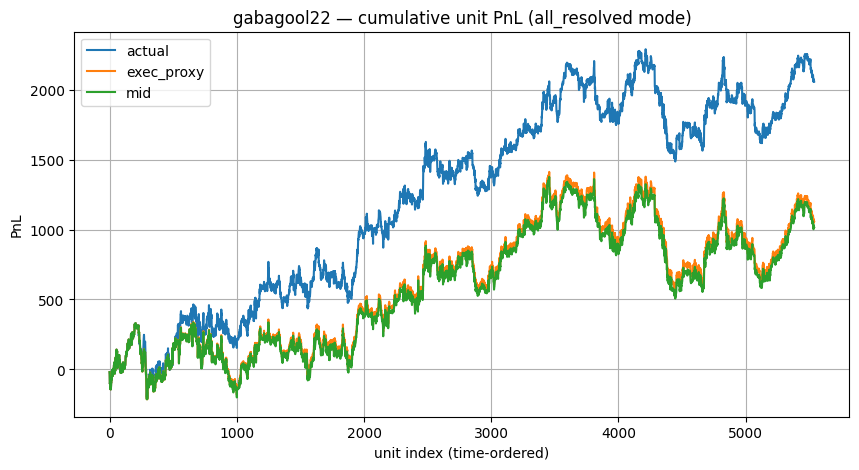

In [7]:
# Equity curves (unit PnL) for a few scenarios.
to_plot = [s for s in ["actual", "exec_proxy", "mid"] if s in units_all]
plt.figure(figsize=(10, 5))
for s in to_plot:
    u = units_all[s]
    pnl = pd.to_numeric(u["pnl"], errors="coerce").fillna(0.0)
    equity = pnl.cumsum()
    plt.plot(equity.to_numpy(), label=s)
plt.title(f"{username} — cumulative unit PnL (all_resolved mode)")
plt.xlabel("unit index (time-ordered)")
plt.ylabel("PnL")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Optional: regime breakdown (actual PnL).
if "regime" in resolved.columns:
    tmp = resolved.copy()
    tmp["pnl"] = compute_trade_pnl(tmp, scenario="actual", fallback_to_actual=True)
    tmp = tmp[tmp["pnl"].notna()].copy()
    g = tmp.groupby("regime")["pnl"]
    pd.DataFrame(
        {
            "trades": g.size(),
            "pnl_sum": g.sum(),
            "pnl_mean": g.mean(),
            "win_rate": g.apply(lambda s: (s > 0).mean()),
        }
    ).sort_values("pnl_sum", ascending=False)
else:
    print("No regime column found.")


## Complete-Set Detection

Detect paired YES/NO (or Up/Down) buys in the same market within a time window.
- **Edge** = 1 - (cost_YES + cost_NO) — if positive, it's risk-free profit at resolution.
- This is a key hypothesis for explaining the gap between `actual` and `exec_proxy`/`mid`.


In [9]:
def detect_complete_sets(df: pd.DataFrame, time_window_sec: int = 60) -> pd.DataFrame:
    """
    Find paired opposite-outcome BUY trades in the same market within a time window.

    Returns DataFrame with matched pairs and their implied edge.
    """
    pairs = []
    seen = set()

    # Filter to BUY trades with relevant outcomes
    buys = df[
        (df["side"] == "BUY") &
        (df["outcome"].isin(["Up", "Down", "Yes", "No"]))
    ].copy()

    for market, grp in buys.groupby("market_slug"):
        grp = grp.sort_values("ts").reset_index(drop=True)
        outcomes = grp["outcome"].unique()

        # Need at least 2 different outcomes for a complete set
        if len(outcomes) < 2:
            continue

        for i, row in grp.iterrows():
            if (market, i) in seen:
                continue

            # Find opposite outcome trades within time window
            opposite = grp[
                (grp["outcome"] != row["outcome"]) &
                (abs((grp["ts"] - row["ts"]).dt.total_seconds()) <= time_window_sec) &
                (~grp.index.isin([idx for m, idx in seen if m == market]))
            ]

            if opposite.empty:
                continue

            # Match with closest trade
            opposite = opposite.copy()
            opposite["time_gap"] = abs((opposite["ts"] - row["ts"]).dt.total_seconds())
            match = opposite.loc[opposite["time_gap"].idxmin()]
            match_idx = opposite["time_gap"].idxmin()

            seen.add((market, i))
            seen.add((market, match_idx))

            min_size = min(row["size"], match["size"])
            combined_cost = row["price"] + match["price"]
            edge = 1 - combined_cost

            pairs.append({
                "market_slug": market,
                "ts_1": row["ts"],
                "outcome_1": row["outcome"],
                "price_1": row["price"],
                "size_1": row["size"],
                "ts_2": match["ts"],
                "outcome_2": match["outcome"],
                "price_2": match["price"],
                "size_2": match["size"],
                "matched_size": min_size,
                "combined_cost": combined_cost,
                "edge": edge,
                "edge_pnl": edge * min_size,
                "time_gap_sec": match["time_gap"],
            })

    return pd.DataFrame(pairs)


In [10]:
# Run complete-set detection on resolved trades
complete_sets = detect_complete_sets(resolved, time_window_sec=60)

print(f"=== Complete-Set Detection Results ===")
print(f"Time window: 60 seconds\n")

if len(complete_sets) > 0:
    total_edge_pnl = complete_sets["edge_pnl"].sum()
    positive_edge = (complete_sets["edge"] > 0).sum()

    print(f"Found {len(complete_sets)} complete-set pairs")
    print(f"Positive edge sets: {positive_edge} / {len(complete_sets)} ({positive_edge/len(complete_sets):.1%})")
    print(f"\nTotal edge PnL (arb profit): ${total_edge_pnl:.2f}")
    print(f"Avg edge per set: {complete_sets['edge'].mean():.4f} ({complete_sets['edge'].mean()*100:.2f}%)")
    print(f"Avg matched size: {complete_sets['matched_size'].mean():.1f} shares")
    print(f"Avg time gap: {complete_sets['time_gap_sec'].mean():.1f} seconds")

    # Compare to total PnL gap
    actual_pnl = summary_all[summary_all["scenario"] == "actual"]["pnl_sum"].values[0]
    mid_pnl = summary_all[summary_all["scenario"] == "mid"]["pnl_sum"].values[0]
    pnl_gap = actual_pnl - mid_pnl

    print(f"\n=== PnL Gap Explanation ===")
    print(f"Actual PnL: ${actual_pnl:.2f}")
    print(f"Mid PnL: ${mid_pnl:.2f}")
    print(f"Gap (actual - mid): ${pnl_gap:.2f}")
    print(f"Complete-set edge explains: ${total_edge_pnl:.2f} ({total_edge_pnl/pnl_gap*100:.1f}% of gap)" if pnl_gap > 0 else "")
else:
    print("No complete-set pairs found within the time window.")


=== Complete-Set Detection Results ===
Time window: 60 seconds

Found 5571 complete-set pairs
Positive edge sets: 2871 / 5571 (51.5%)

Total edge PnL (arb profit): $768.03
Avg edge per set: 0.0113 (1.13%)
Avg matched size: 13.0 shares
Avg time gap: 25.4 seconds

=== PnL Gap Explanation ===
Actual PnL: $2057.87
Mid PnL: $1016.19
Gap (actual - mid): $1041.68
Complete-set edge explains: $768.03 (73.7% of gap)


In [11]:
# Show top complete-set markets
if len(complete_sets) > 0:
    print("Top 10 markets by complete-set edge PnL:")
    display(
        complete_sets.nlargest(10, "edge_pnl")[
            ["market_slug", "outcome_1", "price_1", "outcome_2", "price_2",
             "combined_cost", "edge", "matched_size", "edge_pnl", "time_gap_sec"]
        ].round(4)
    )


Top 10 markets by complete-set edge PnL:


,market_slug,outcome_1,price_1,outcome_2,price_2,combined_cost,edge,matched_size,edge_pnl,time_gap_sec
2325,btc-updown-15m-1765809000,Up,0.3325,Down,0.12,0.4525,0.5475,19.0,10.4025,50.0
1428,btc-updown-15m-1765731600,Down,0.2200,Up,0.08,0.3000,0.7000,12.0,8.4000,24.0
1426,btc-updown-15m-1765731600,Down,0.2400,Up,0.16,0.4000,0.6000,12.0,7.2000,60.0
1427,btc-updown-15m-1765731600,Down,0.2400,Up,0.16,0.4000,0.6000,12.0,7.2000,60.0
1768,btc-updown-15m-1765741500,Down,0.4000,Up,0.25,0.6500,0.3500,20.0,7.0000,46.0
1015,btc-updown-15m-1765723500,Down,0.2500,Up,0.42,0.6700,0.3300,20.0,6.6000,44.0
3380,btc-updown-15m-1765891800,Down,0.2600,Up,0.41,0.6700,0.3300,20.0,6.6000,24.0
5019,eth-updown-15m-1765893600,Down,0.3600,Up,0.21,0.5700,0.4300,14.0,6.0200,50.0
1770,btc-updown-15m-1765741500,Down,0.4200,Up,0.29,0.7100,0.2900,20.0,5.8000,54.0
2172,btc-updown-15m-1765807200,Up,0.4500,Down,0.26,0.7100,0.2900,20.0,5.8000,50.0


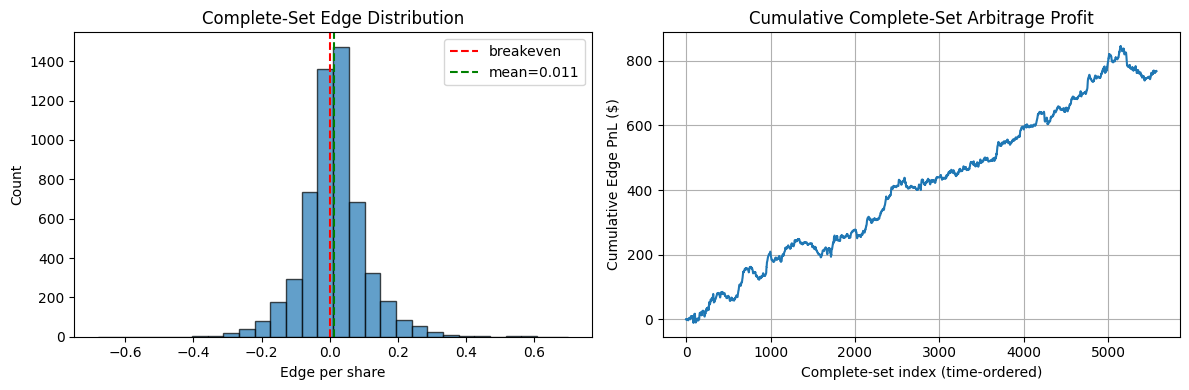

In [12]:
# Visualize edge distribution
if len(complete_sets) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Edge distribution
    axes[0].hist(complete_sets["edge"], bins=30, edgecolor="black", alpha=0.7)
    axes[0].axvline(x=0, color="red", linestyle="--", label="breakeven")
    axes[0].axvline(x=complete_sets["edge"].mean(), color="green", linestyle="--", label=f"mean={complete_sets['edge'].mean():.3f}")
    axes[0].set_xlabel("Edge per share")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Complete-Set Edge Distribution")
    axes[0].legend()

    # Cumulative edge PnL
    cs_sorted = complete_sets.sort_values("ts_1").reset_index(drop=True)
    cs_sorted["cumulative_edge_pnl"] = cs_sorted["edge_pnl"].cumsum()
    axes[1].plot(cs_sorted["cumulative_edge_pnl"])
    axes[1].set_xlabel("Complete-set index (time-ordered)")
    axes[1].set_ylabel("Cumulative Edge PnL ($)")
    axes[1].set_title("Cumulative Complete-Set Arbitrage Profit")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [13]:
# Save complete-set results
if len(complete_sets) > 0:
    cs_path = loaded.snapshot_path / "complete_sets.csv"
    complete_sets.to_csv(cs_path, index=False)
    print("wrote:", cs_path)


wrote: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251216T171416+0000/complete_sets.csv


In [14]:
# Save summaries next to the snapshot for reproducibility.
out_dir = loaded.snapshot_path
summary_all_path = out_dir / "backtest_summary_all_resolved.csv"
summary_tob_path = out_dir / "backtest_summary_tob_known_only.csv"

summary_all.to_csv(summary_all_path, index=False)
summary_tob.to_csv(summary_tob_path, index=False)

print("wrote:", summary_all_path)
print("wrote:", summary_tob_path)


wrote: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251216T171416+0000/backtest_summary_all_resolved.csv
wrote: /Users/antoniostano/programming/polybot/research/data/snapshots/gabagool22-20251216T171416+0000/backtest_summary_tob_known_only.csv
